# Explanation Scope

### Global Explanations

Global explanations aim to provide an overall understanding of how a machine learning model makes decisions, regardless of individual instances. These explanations seek to answer questions about the model's general behavior and logic across the entire input space. Global explanations are particularly useful for gaining insights into the model's decision-making process as a whole, identifying potential biases in the model, and understanding the relative importance of different input features.

**Examples of Global Explanations:**

- **Feature Importance:** Techniques such as permutation feature importance can be used to measure the impact of each feature on the model's predictions across the entire dataset.
- **Model Visualizations:** For some models, like decision trees, the entire model structure can be visualized, offering a global view of how decisions are made.
- **Rule Extraction:** Generating a set of rules that approximate the behavior of the model across all possible inputs.

let's see an example of "Feature importance":

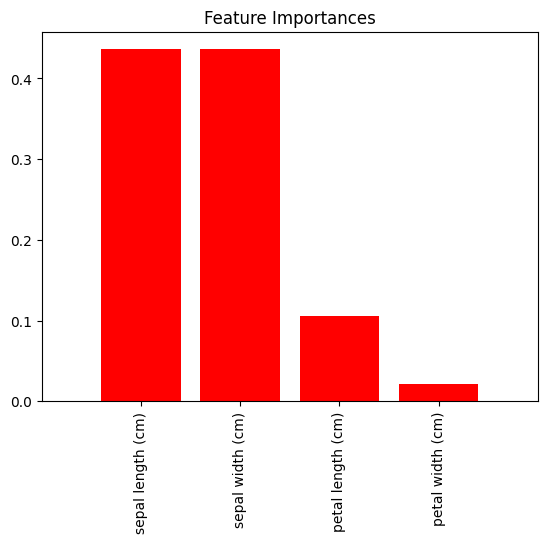

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Create and train the RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get the feature importances
importances = model.feature_importances_

# Sort the feature importances in descending order:
# The following line is a compact way to obtain the indices
# of the elements in importances sorted from the highest importance to the lowest. 
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), iris.feature_names, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Local Explanations

In contrast, local explanations focus on explaining the prediction of a machine learning model for a single instance or a small group of instances. This type of explanation is crucial when we need to understand the specific reasons behind a particular decision made by the model, such as why a loan application was denied or why a medical diagnosis was given. Local explanations provide detailed insights into the decision-making process for individual predictions, which can be critical for applications where accountability and transparency are essential.

Let's see an example of SHAP library, used to generate a local explanation:

In [69]:
import xgboost
import shap
import warnings
warnings.filterwarnings('ignore')

# train an XGBoost model
X, y = shap.datasets.california()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[10])

The force_plot visualization provides a detailed view of the contribution of each feature to the prediction for an individual instance. Features pushing the prediction higher are shown in red, while those pushing the prediction lower are in blue. This insight is invaluable for understanding why the model made a specific prediction, helping to demystify the decision-making process of complex models.

When interpreting a force plot, here's how the base value fits into the overall explanation:

- **Base Value:** It is the value that would be predicted if we did not know any features for the current instance. In other words, it's the model's output when no specific information is provided. For a classification model, this could be the log odds of the positive class in a binary classifier or the probabilities of each class in a multi-class classifier. For a regression model, it's the average outcome.

In [78]:
pp = sum([p for p in shap_values[10].values if p > 0])

In [79]:
nn = sum([n for n in shap_values[10].values if n < 0])

In [80]:
pp + nn

0.2955085774883628

In [96]:
model.predict(X)[10] - shap_values[10].base_values

0.29550862

- **SHAP Values:** Each feature's SHAP value indicates how the presence of this feature in the current instance shifts the prediction from the base value to the final model prediction. Features pushing the prediction higher than the base value are shown in one color (e.g., red), and those pushing the prediction lower are shown in another color (e.g., blue).

The force plot visually represents this shift for each feature, starting from the base value and adding each feature's effect, leading up to the final prediction. This way, you can see which features have the most significant impact on the prediction and in which direction.

The concept of a base value is fundamental in SHAP and many other interpretability methods because it establishes a reference point from which the contributions of individual features can be assessed. This helps in understanding not just how the model arrived at a particular prediction, but also in comparing the relative importance and effects of different features on the model's decisions.

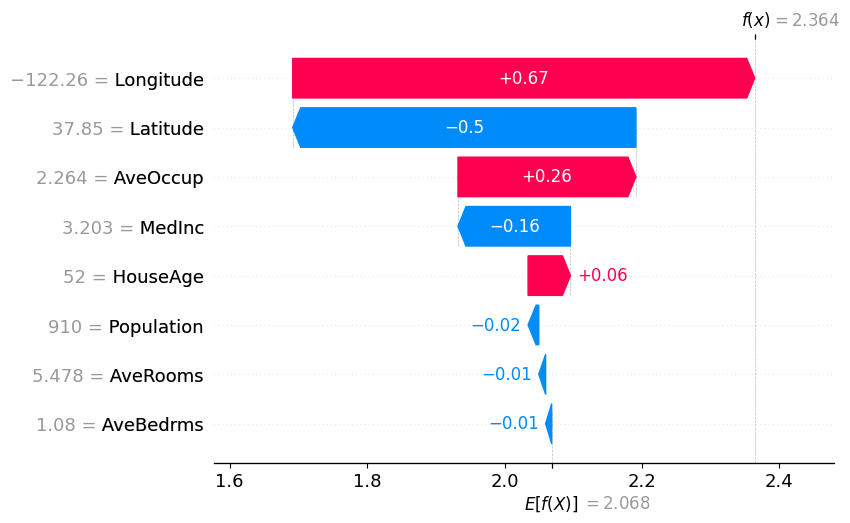

In [98]:
shap.plots.waterfall(shap_values[10])


# Explanation Type

XAI provides various types of explanations to help users understand AI model decisions. Among these, plain-fact, counterfactual, and contrastive explanations stand out for their specific approaches to clarifying model behavior.

### Plain-Fact Explanations

**Definition:**
Plain-fact explanations provide straightforward information about the model's decision without comparing it to alternative outcomes. These explanations usually focus on the direct reasons or factors leading to a decision.

**Example:**
Imagine a loan approval model that decides whether to approve or reject loan applications. A plain-fact explanation for a rejected loan might be, "Your loan application was rejected because your credit score is 580, which is below our minimum requirement of 600."

### Counterfactual Explanations

**Definition:**
Counterfactual explanations describe how a different outcome could have been achieved by altering some aspects of the input. They are essentially "if-then" statements that provide insight into how to change the outcome.

**Example:**
Continuing with the loan approval model, a counterfactual explanation for the same rejected loan application might be, "Your loan application would have been approved if your credit score were at least 600."

In [ ]:
#pip install dice-ml

In [8]:
import dice_ml
from dice_ml.utils import helpers  # helper functions
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

dataset = helpers.load_adult_income_dataset()
target = dataset["income"]  # outcome variable
train_dataset, test_dataset, _, _ = train_test_split(dataset,
                                                     target,
                                                     test_size=0.2,
                                                     random_state=0,
                                                     stratify=target)
# Dataset for training an ML model
d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=['age', 'hours_per_week'],
                 outcome_name='income')

# Pre-trained ML model
m = dice_ml.Model(
    model_path=dice_ml.utils.helpers.get_adult_income_modelpath(),
    backend='TF2',
    func="ohe-min-max")
# DiCE explanation instance
exp = dice_ml.Dice(d, m)

In [9]:
# Generate counterfactual examples
query_instance = test_dataset.drop(columns="income")[0:1]
dice_exp = exp.generate_counterfactuals(query_instance,
                                        total_CFs=4,
                                        desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]

Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0



Diverse Counterfactual set (new outcome: 1)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,88,1
1,44,Private,HS-grad,Married,Other/Unknown,White,Female,38,1
2,29,Government,Assoc,Married,Blue-Collar,White,Female,38,1
3,29,Private,HS-grad,Married,Blue-Collar,White,Female,70,1


### Contrastive Explanations

**Definition:**
Contrastive explanations focus on the difference between the actual outcome and a specific alternative outcome that did not occur. They explain why one outcome happened instead of another, highlighting the factors that led to the decision over possible alternatives.

**Example:**
For the rejected loan application, a contrastive explanation could be, "Your loan application was rejected instead of approved because your credit score is 580, not 600 or higher. Applicants with scores of 600 or higher meet our creditworthiness criteria."

###  Comparison:

- **Plain-Fact Explanations** offer direct reasons for a decision, focusing on the actual factors that influenced the outcome. They are straightforward but may not provide insight into how to change the outcome.
- **Counterfactual Explanations** provide a hypothetical scenario that would lead to a different decision, offering a clear path for changing the outcome. They are particularly useful for understanding the minimum changes needed to achieve a desired result.
- **Contrastive Explanations** compare the actual decision to an alternative, explaining why one occurred over the other. They help understand the decision-making process by highlighting the crucial differences between two scenarios.

Each type of explanation has its own strengths and is suited to different contexts and user needs. Plain-fact explanations are easy to understand but might lack actionable insights. Counterfactual explanations are powerful for identifying actionable changes but might oversimplify complex decisions. Contrastive explanations provide a deep understanding of the decision-making process but can be more complex to interpret.